In [1]:
from utils import Database, plot_timeseries
from clustering import kmeans_cluster
import pandas as pd
import numpy as np

In [2]:
GLOBAL_SEED = 0

# Предобработка данных

Разобъем данные на 4 датафрейма c сессиями: trading_type $= \{\rm daily, montly\} \times$ platform_id = \{1, 2\}. В дневных торгах временной ряд будет состоять из 30 точек, соответсвующих минуте торгов, в месячных -- из 60 точек.

Кажется логичным искать похожие сессии среди сессий одного типа, проходящих на одной платформе

In [3]:
db = Database("trade_info.sqlite3")

In [4]:
monthly1_pr, _ = db.get_timeseries(trading_type="monthly", platform_id=1, normalize="uniform")

In [5]:
monthly1_pr.head()

,session_id,min_0,min_1,min_2,min_3,min_4,min_5,min_6,min_7,min_8,...,min_50,min_51,min_52,min_53,min_54,min_55,min_56,min_57,min_58,min_59
0,27,-2.759346,-2.759346,-2.759346,-2.759346,2.875867,2.875867,2.875867,0.179218,0.179218,...,0.061116,0.061116,0.061116,0.061116,0.061116,0.061116,0.061116,0.061116,0.061116,-1.789045
1,30,-0.928847,-0.928847,-0.928847,2.450727,2.450727,2.450727,2.450727,0.988504,0.988504,...,-0.447638,-0.447638,-0.473718,-0.473718,-0.473718,-0.473718,-0.473718,-0.473718,-1.935941,-3.088848
2,35,3.288870,3.288870,3.288870,3.288870,3.288870,-0.298988,-0.298988,-0.298988,-0.298988,...,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988
3,37,0.516576,0.516576,0.516576,0.516576,0.516576,0.516576,0.516576,0.516576,0.516576,...,-0.672141,-0.672141,-0.672141,-0.672141,-0.672141,-0.672141,-0.672141,-1.481782,-1.481782,-6.023376
4,39,1.340997,1.340997,1.340997,0.499068,0.499068,2.233139,2.233139,0.499068,0.499068,...,-0.590919,1.985415,1.985415,1.985415,1.512904,-0.491829,-0.535619,0.003620,-0.491829,-0.750230


In [6]:
monthly1_pr.shape

(26, 61)

In [7]:
monthly2_pr, _ = db.get_timeseries(trading_type="monthly", platform_id=2, normalize="uniform")

In [8]:
monthly2_pr.head()

,session_id,min_0,min_1,min_2,min_3,min_4,min_5,min_6,min_7,min_8,...,min_50,min_51,min_52,min_53,min_54,min_55,min_56,min_57,min_58,min_59
0,28,-0.193295,-0.193295,-0.193295,-0.193295,-0.193295,-0.193295,-0.193295,-0.193295,-0.193295,...,1.381870,1.381870,1.381870,1.381870,1.381870,1.381870,1.381870,1.381870,1.381870,-0.193295
1,29,2.219140,1.428089,1.124182,2.187855,2.187855,2.187855,2.187855,0.504447,1.124182,...,-1.115101,-1.115101,-1.115101,-1.115101,-1.115101,-1.115101,-1.115101,-1.115101,-1.215899,-1.367790
2,36,3.288870,3.288870,3.288870,3.288870,3.288870,-0.298988,-0.298988,-0.298988,-0.298988,...,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988
3,38,1.638522,1.638522,1.926806,1.926806,1.926806,1.926806,1.926806,1.926806,1.926806,...,0.004913,0.004913,0.006433,0.485386,0.485386,0.485386,0.485386,0.485386,0.485386,0.965859
4,40,-0.264702,-0.264702,-0.264702,1.486460,1.486460,1.486460,1.486460,1.486460,1.486460,...,-0.439818,-0.439818,-0.439818,-0.439818,-0.439818,-0.264702,-0.342089,0.610879,-0.264702,-0.264702


In [9]:
monthly2_pr.shape

(26, 61)

Поскольку данных не так много, давайте все таки искать похожие среди всех месячных сессий

In [10]:
monthly = pd.concat((monthly1_pr, monthly2_pr), ignore_index=True)
monthly.head()

,session_id,min_0,min_1,min_2,min_3,min_4,min_5,min_6,min_7,min_8,...,min_50,min_51,min_52,min_53,min_54,min_55,min_56,min_57,min_58,min_59
0,27,-2.759346,-2.759346,-2.759346,-2.759346,2.875867,2.875867,2.875867,0.179218,0.179218,...,0.061116,0.061116,0.061116,0.061116,0.061116,0.061116,0.061116,0.061116,0.061116,-1.789045
1,30,-0.928847,-0.928847,-0.928847,2.450727,2.450727,2.450727,2.450727,0.988504,0.988504,...,-0.447638,-0.447638,-0.473718,-0.473718,-0.473718,-0.473718,-0.473718,-0.473718,-1.935941,-3.088848
2,35,3.288870,3.288870,3.288870,3.288870,3.288870,-0.298988,-0.298988,-0.298988,-0.298988,...,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988,-0.298988
3,37,0.516576,0.516576,0.516576,0.516576,0.516576,0.516576,0.516576,0.516576,0.516576,...,-0.672141,-0.672141,-0.672141,-0.672141,-0.672141,-0.672141,-0.672141,-1.481782,-1.481782,-6.023376
4,39,1.340997,1.340997,1.340997,0.499068,0.499068,2.233139,2.233139,0.499068,0.499068,...,-0.590919,1.985415,1.985415,1.985415,1.512904,-0.491829,-0.535619,0.003620,-0.491829,-0.750230


In [11]:
monthly.shape

(52, 61)

# Кластеризация

## Cosine distance

In [12]:
time_series = monthly.iloc[:, 1:].values

In [13]:
labels = kmeans_cluster(time_series, metric='cosine', n_centers=5, seed=GLOBAL_SEED)

In [14]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 6, 15, 15,  8,  8]))

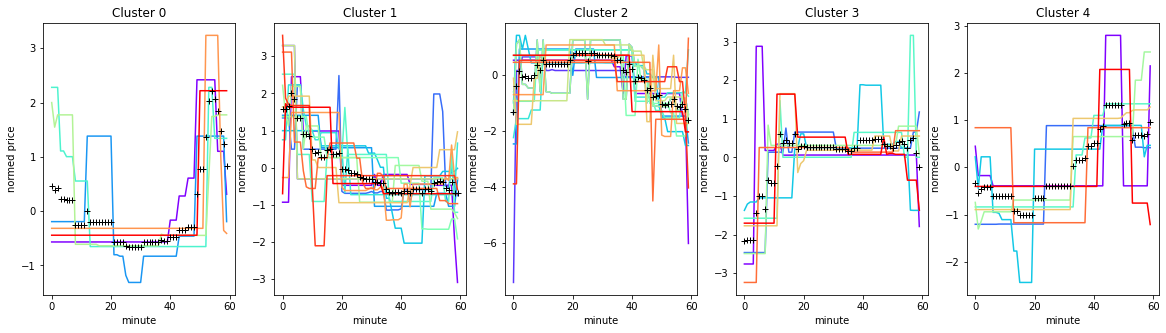

In [15]:
plot_timeseries(time_series, labels, size=(20, 5))

Заметим, что $\rm 2 dist_{cos}(x, y) = dist_{\ell_2}\left(\frac{x}{\|x\|}, \frac{y}{\|y\|}\right)$. Поэтому для кластеризации по косинусному расстоянию используем просто KMeans с евклидовым расстоянием, но только нормируем временные ряды к единичной норме.

Получившиеся кластеры можно описать примерно следующим образом:

<ol>
    <li> Сессии со скачком цены перед концом сессиия</li>
    <li> Сессии, в которых цена в среднем падает от начала к концу сессии</li>
    <li> Сессии, в которых наблюдается падение цены перед закрытием</li>
    <li> Сессии, открывающиеся ростом цены, а потом выходящие на плато (в среднем)</li>
    <li> Сессии с ростом цены от середины к концу сессии, но в конце может произойти, что угодно. По сути похоже на паттерн из 1ого (нулевого на картинках) кластера</li>

</ol>

## MAE

Тут заметим, что в пространсве с $\ell_1$ расстоянием непонятно как считать центр масс (как и другие пространственные интегралы), поэтому KMeans нам не подойдет, а DBSCAN ок. 

In [16]:
labels = kmeans_cluster(time_series, metric='mae', n_centers=5, seed=GLOBAL_SEED, eps=32, min_samples=4)
np.unique(labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4]), array([21,  5,  9,  6,  7,  4]))

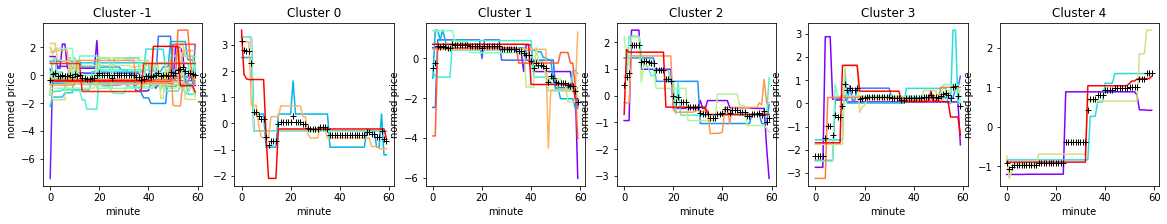

In [17]:
plot_timeseries(time_series, labels)

Тут (минус) первый класс соответствует выбросам, то есть точкам в $\epsilon$-окрестности которых лежит меньше 4х примеров. Видно, что таких большинство, значит, что по $\ell_1$ расстоянию точки довольно изолированы друг от друга. При этом если взять $\epsilon$ еще больше, то все сольется  в несколько кластеров, значит они еще и довольно равноудалены друг от друга. Одним словом MAE, так себе метрика для кластеризации временных рядов.

Однако внутри кластеров все же прослеживаются некоторые патерны:
<ol>
    <li> Класс аутлайеров. Просто шум с нулевым средним</li>
    <li> Цена резко падает в начале сессии, потом плато с небольшим затуханием</li>
    <li> Открытие сессии небольшим скачком, потом плато, потом падение цены</li>
    <li> Открытие сессии ростом с быстрой сменой тренда на более-менее равномерное затухание цены до конца сессии</li>
    <li> Какие-то скачки цены вначале сессии, небольшой отскок, и потом без изменений</li>
    <li> Открытие без изменеий цены, затем довольно резкий рост, до конца сессии</li>
</ol>

## DTW

In [18]:
labels = kmeans_cluster(time_series, metric='dtw', n_centers=5, seed=GLOBAL_SEED)
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 5, 13, 13, 14,  7]))

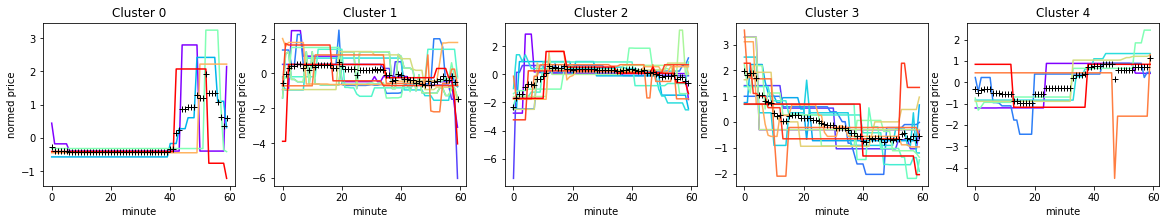

In [19]:
plot_timeseries(time_series, labels)

Тут тоже выделяется кластеры, некоторые из которых мы уже встречали ранее:
<ol>
    <li> Незменная цена от начала и почти до конца сессии, замем кратковременный скачок цены с отскоком до прежнего значения</li>
    <li> Более-менее хаотичные колебания цены в районе середней</li>
    <li> Открытие сессии ростом, потом плато с элементами затухания</li>
    <li> Более-мене равномерное затухание от начала к концу сессии</li>
    <li> Как будто четко выраженного патерна нет :(</li>
 
</ol>

Можно попытаться как-то интерпретировать результаты. Например, понятно, что близкие по косинусному расстоянию временные ряды должны быть одного знака на большей части тайм стемпов. Поэтому там нет кластеров с паттерном осциляций вокруг нуля, как например аутлайеры в MAE и Cluster 1 в DTW. 


Какие-то еще глубокие выводы сделать сложно, но видно, что среди всех трех расстояний встречаются кластеры с похожими паттернами. Пример: Cluster 1 cosine, Cluster 0 MAE, Cluster 3 DTW. Но в целом по MAE временные ряды более разрежены и хуже группируются.